# <span style="color:orange">**Training notebook (+ predictions)**</span>
- This notebook trains (and saves) one model per target to predict. It also creates test predictions and generates a submission.parquet file.
- To train models, you must generate the train and test CSV file with the 1st notebook (1_Feature_extraction.ipynb).
- During the contest, I faced big overfitting issues. I reached a CV of ~0.67 with feature selection and hyperparameter finetuning, but the leaderboard score only reached 0.63.
- In the end, I choosed a solution that I never sent, but that should have a better correlation CV/Leaderboard (around 0.64-0.65).

<u>Things that worked :</u>
- Use optuna to search for customed and optimized threshods to improve the f1-score.
- For each target, adjust the number of folds depending of its number of classes (to avoid overfitting). This reduced CV but improved the leaderboard score.
- Use post-processing to manually set some target values. However, only ~10 correct values can be found that way, which practically doesn't change anything in the final score.
- Use regression instead of classification for some numerical-like targets. But in the end, I did not have the time to use this code.

<u>Things that didn't work :</u>
- Ensemble of models didn't really work, so I only use one model per target in my final solution.
- Train one model for both residential and commercial buillding for similar targets (colling and heating setpoints).
___

## **Librairies**

In [1]:
# Import useful librairies
from utils_librairies import *

## **Directory Paths**

In [2]:
# Import useful paths
from utils_paths import *

## **Utils**

In [3]:
# Import useful functions
from utils_models import *

# Import function provided by the competition organizers (for CV computation)
from utils import calculate_hierarchical_f1_score

___
___
# **Open files**

#### **Train**

In [4]:
%%time

# Open train df 
df = pd.read_csv("df_train.csv")

# Sort
df = df.sort_values(by = ['bldg_id']).reset_index(drop=True)

# Show
print(df.shape)
df.head()

(7200, 53677)
CPU times: user 7min 11s, sys: 11 s, total: 7min 22s
Wall time: 7min 26s


,bldg_id,in.state,n_percent_diff_from_last_quarter_greater_than_positive_2%,n_percent_diff_from_last_quarter_lower_than_negative_2%,n_percent_diff_from_last_quarter_greater_than_positive_4%,n_percent_diff_from_last_quarter_lower_than_negative_4%,n_percent_diff_from_last_quarter_greater_than_positive_6%,n_percent_diff_from_last_quarter_lower_than_negative_6%,n_percent_diff_from_last_quarter_greater_than_positive_8%,n_percent_diff_from_last_quarter_lower_than_negative_8%,n_percent_diff_from_last_quarter_greater_than_positive_10%,n_percent_diff_from_last_quarter_lower_than_negative_10%,n_percent_diff_from_last_quarter_greater_than_positive_15%,n_percent_diff_from_last_quarter_lower_than_negative_15%,n_percent_diff_from_last_quarter_greater_than_positive_20%,n_percent_diff_from_last_quarter_lower_than_negative_20%,n_percent_diff_from_last_quarter_greater_than_positive_25%,n_percent_diff_from_last_quarter_lower_than_negative_25%,n_percent_diff_from_last_quarter_greater_than_positive_30%,n_percent_diff_from_last_quarter_lower_than_negative_30%,n_percent_diff_from_last_quarter_greater_than_positive_35%,n_percent_diff_from_last_quarter_lower_than_negative_35%,n_percent_diff_from_last_quarter_greater_than_positive_40%,n_percent_diff_from_last_quarter_lower_than_negative_40%,n_percent_diff_from_last_quarter_greater_than_positive_45%,n_percent_diff_from_last_quarter_lower_than_negative_45%,n_percent_diff_from_last_quarter_greater_than_positive_50%,n_percent_diff_from_last_quarter_lower_than_negative_50%,n_percent_diff_from_last_quarter_greater_than_positive_55%,n_percent_diff_from_last_quarter_lower_than_negative_55%,n_percent_diff_from_last_quarter_greater_than_positive_60%,n_percent_diff_from_last_quarter_lower_than_negative_60%,n_percent_diff_from_last_quarter_greater_than_positive_65%,n_percent_diff_from_last_quarter_lower_than_negative_65%,n_percent_diff_from_last_quarter_greater_than_positive_70%,n_percent_diff_from_last_quarter_lower_than_negative_70%,n_percent_diff_from_last_quarter_greater_than_positive_75%,n_percent_diff_from_last_quarter_lower_than_negative_75%,n_percent_diff_from_last_quarter_greater_than_positive_80%,n_percent_diff_from_last_quarter_lower_than_negative_80%,n_percent_diff_from_last_quarter_greater_than_positive_85%,n_percent_diff_from_last_quarter_lower_than_negative_85%,n_percent_diff_from_last_quarter_greater_than_positive_90%,n_percent_diff_from_last_quarter_lower_than_negative_90%,n_percent_diff_from_last_quarter_greater_than_positive_95%,n_percent_diff_from_last_quarter_lower_than_negative_95%,n_percent_diff_from_last_quarter_greater_than_positive_100%,n_percent_diff_from_last_quarter_lower_than_negative_100%,n_percent_diff_from_next_quarter_greater_than_positive_2%,n_percent_diff_from_next_quarter_lower_than_negative_2%,...,month9_energy_max_of_mins,month9_energy_min_of_maxs,month10_energy_max_of_mins,month10_energy_min_of_maxs,month11_energy_max_of_mins,month11_energy_min_of_maxs,month12_energy_max_of_mins,month12_energy_min_of_maxs,Max_of_mins_value_MAX_month,Max_of_mins_value_MIN_month,Min_of_maxs_value_MAX_month,Min_of_maxs_value_MIN_month,Max_of_mins_value_MAX_reached_at_month,Max_of_mins_value_MIN_reached_at_month,Min_of_maxs_value_MAX_reached_at_month,Min_of_maxs_value_MIN_reached_at_month,season0_energy_max_of_mins,season0_energy_min_of_maxs,season1_energy_max_of_mins,season1_energy_min_of_maxs,season2_energy_max_of_mins,season2_energy_min_of_maxs,season3_energy_max_of_mins,season3_energy_min_of_maxs,season4_energy_max_of_mins,season4_energy_min_of_maxs,Max_of_mins_value_MAX_season,Max_of_mins_value_MIN_season,Min_of_maxs_value_MAX_season,Min_of_maxs_value_MIN_season,Max_of_mins_value_MAX_reached_at_season,Max_of_mins_value_MIN_reached_at_season,Min_of_maxs_value_MAX_reached_at_season,Min_of_maxs_value_MIN_reached_at_season,is_holiday0_energy_max_of_mins,is_holiday0_energy_min_of_maxs,is_holiday1_energy_max_of_mins,is_holiday1_energy_min_of_maxs,Max_of_mins_value_MAX_is_holiday,Max_of_mins_value

#### **Test**

In [5]:
%%time

# Open test df
test = pd.read_csv("df_test.csv")

# Sort
test = test.sort_values(by = ['bldg_id']).reset_index(drop=True)

# Show
print(test.shape)
test.head(1)

(1440, 11021)
CPU times: user 6.23 s, sys: 138 ms, total: 6.37 s
Wall time: 6.43 s


,bldg_id,FFT_date_sum_15th_value,FFT_date_sum_2th_value,FFT_date_sum_5th_value,FFT_date_sum_9th_value,FFT_dayofweek_mean_2th_value,FFT_dayofweek_mean_3th_value,FFT_dayofweek_mean_4th_value,FFT_dayofweek_sum_3th_value,FFT_dayofweek_sum_4th_value,FFT_hour_mean_7th_value,FFT_hour_mean_8th_value,FFT_hour_minute_mean_3th_value,FFT_hour_minute_mean_4th_value,FFT_hour_minute_mean_5th_value,FFT_hour_minute_mean_6th_value,FFT_hour_minute_mean_9th_value,FFT_hour_minute_sum_10th_value,FFT_hour_minute_sum_12th_value,FFT_hour_minute_sum_15th_value,FFT_hour_minute_sum_4th_value,FFT_hour_sum_10th_value,FFT_hour_sum_11th_value,FFT_hour_sum_9th_value,FFT_week_mean_5th_value,FFT_week_sum_14th_value,FFT_week_sum_2th_value,FFT_week_sum_6th_value,FFT_week_sum_8th_value,MEAN_closing_quarter_estimation,MEAN_operating_hours_estimation_1,MEAN_operating_hours_estimation_MAX,MEDIAN_closing_quarter_estimation,MEDIAN_operating_hours_estimation_1,MEDIAN_operating_hours_estimation_MAX,STD_closing_quarter_estimation,STD_opening_quarter_estimation,STD_operating_hours_estimation,STD_operating_hours_estimation_1,STD_operating_hours_estimation_2,STD_operating_hours_estimation_3,STD_operating_hours_estimation_MAX,STD_operating_hours_estimation_MIN,autumn_weekend_ratio_is_equal_to_last_or_next_quarter,closing_diff_56th_quarter,closing_diff_56th_quarter_summer,closing_diff_56th_quarter_winter,closing_diff_57th_quarter,closing_diff_57th_quarter_all_year,closing_diff_57th_quarter_summer,...,10_45_energy_sum_diff_to_smooth,11_30_energy_sum_diff_to_smooth,06_00_abs_diff_sum,12_45_diff_sum,07_00_energy_max,05_45_energy_max,20_15_energy_max,21_15_energy_min,13_45_energy_max,06_00_energy_sum,21_00_energy_min,18_15_abs_diff_sum,23_45_energy_sum,16_45_energy_sum_diff_to_smooth,09_15_energy_sum,16_45_energy_max,19_00_diff_sum,08_30_energy_sum,19_45_energy_sum,19_45_energy_max,13_15_abs_diff_sum,15_15_diff_std,22_45_energy_min,00_45_energy_sum_diff_to_smooth,18_15_energy_max,19_00_energy_sum_diff_to_smooth,19_00_energy_min,19_00_energy_max,14_15_diff_sum,09_45_energy_min,06_45_energy_sum,05_45_energy_std,20_45_diff_sum,21_30_abs_diff_sum,07_00_energy_sum,05_30_energy_std,13_30_energy_sum_diff_to_smooth,13_15_energy_std,3th_inflexion_point_energy_std,06_45_energy_max,06_15_energy_max,15_00_energy_max,14_45_diff_std,14_30_diff_std,08_15_energy_sum,17_15_energy_std,15_00_diff_std,21_00_energy_std,14_15_energy_sum_diff_to_smooth,21_45_diff_sum
0,1,32.787938,478.380931,27.572189,152.900216,0.02589,0.0105,0.003272,36.46169,33.705276,0.058674,0.0387,1.353775,0.034507,0.515311,0.538501,0.1728,40.168412,89.619237,61.202093,12.594908,54.153985,76.656401,78.035685,0.044964,25.855414,443.014861,62.265882,28.934724,82.25,14.3125,16.3125,80.0,14.75,16.5,5.868347,7.614747,2.055433,2.419808,1.089725,0.811899,1.384907,2.05396,0.766857,0.051358,0.005098,-0.003048,0.008321,0.004608,-0.001118,...,-0.135649,-0.734323,0.459831,-0.986626,0.567679,0.641721,0.885567,1.767193,0.695031,0.152942,1.767193,0.515848,-1.543415,0.388018,1.578559,-0.527161,0.041625,0.742622,0.108072,0.402811,0.527313,-1.081141,1.138858,-0.302393,0.810538,-0.707843,2.081361,0.59927,0.597457,-1.060316,0.189427,0.39821,1.446603,0.677838,0.545522,0.387219,-0.171047,-0.185625,70,-0.860845,0.793755,0.800665,-0.430905,0.165992,1.732315,0.423095,0.825955,0.48392,0.51316,-0.65023


#### **Targets**

In [6]:
# Open labels
df_targets = pd.read_parquet(filedir + "train_label.parquet", engine='pyarrow')

# Reset index
df_targets = df_targets.reset_index()

# Columns
cols_residential = [x for x in df_targets.columns if x.endswith('_res')]
cols_commercial  = [x for x in df_targets.columns if x.endswith('_com')]

# Show
print(df_targets.shape)
df_targets.head()

(7200, 26)


,bldg_id,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,in.weekday_opening_time..hr_com,in.weekday_operating_hours..hr_com,in.bedrooms_res,in.cooling_setpoint_res,in.heating_setpoint_res,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res
0,1,residential,None,None,None,None,None,None,None,None,None,None,None,3,68F,75F,Multi-Family with 2 - 4 Units,1500-1999,Unheated Basement,Wood Frame,Natural Gas,100000-119999,Composition Shingles,Owner,Occupied,<1940
1,2,residential,None,None,None,None,None,None,None,None,None,None,None,2,75F,72F,Multi-Family with 5+ Units,750-999,Vented Crawlspace,Wood Frame,Natural Gas,10000-14999,"Asphalt Shingles, Medium",Renter,Occupied,1970s
2,3,commercial,Warehouse and Storage,Electricity,Small Packaged Unit,2,owner_occupied,1990 to 1999,WoodFramed,999,999,8.25,9.25,None,None,None,None,None,None,None,None,None,None,None,None,None
3,4,residential,None,None,None,None,None,None,None,None,None,None,None,1,72F,68F,Multi-Family with 5+ Units,1000-1499,Vented Crawlspace,Wood Frame,Electricity,60000-69999,"Asphalt Shingles, Medium",Renter,Occupied,1980s
4,5,commercial,Warehouse and Storage,NaturalGas,Residential Style Central Systems,1,owner_occupied,2000 to 2012,WoodFramed,999,999,7,8,None,None,None,None,None,None,None,None,None,None,None,None,None


#### **Add labels to training data**

In [7]:
# Merge to add labels
df = pd.merge(df, df_targets, how='left', on='bldg_id')

# Show
print(df.shape)
df.head()

(7200, 53702)


,bldg_id,in.state,n_percent_diff_from_last_quarter_greater_than_positive_2%,n_percent_diff_from_last_quarter_lower_than_negative_2%,n_percent_diff_from_last_quarter_greater_than_positive_4%,n_percent_diff_from_last_quarter_lower_than_negative_4%,n_percent_diff_from_last_quarter_greater_than_positive_6%,n_percent_diff_from_last_quarter_lower_than_negative_6%,n_percent_diff_from_last_quarter_greater_than_positive_8%,n_percent_diff_from_last_quarter_lower_than_negative_8%,n_percent_diff_from_last_quarter_greater_than_positive_10%,n_percent_diff_from_last_quarter_lower_than_negative_10%,n_percent_diff_from_last_quarter_greater_than_positive_15%,n_percent_diff_from_last_quarter_lower_than_negative_15%,n_percent_diff_from_last_quarter_greater_than_positive_20%,n_percent_diff_from_last_quarter_lower_than_negative_20%,n_percent_diff_from_last_quarter_greater_than_positive_25%,n_percent_diff_from_last_quarter_lower_than_negative_25%,n_percent_diff_from_last_quarter_greater_than_positive_30%,n_percent_diff_from_last_quarter_lower_than_negative_30%,n_percent_diff_from_last_quarter_greater_than_positive_35%,n_percent_diff_from_last_quarter_lower_than_negative_35%,n_percent_diff_from_last_quarter_greater_than_positive_40%,n_percent_diff_from_last_quarter_lower_than_negative_40%,n_percent_diff_from_last_quarter_greater_than_positive_45%,n_percent_diff_from_last_quarter_lower_than_negative_45%,n_percent_diff_from_last_quarter_greater_than_positive_50%,n_percent_diff_from_last_quarter_lower_than_negative_50%,n_percent_diff_from_last_quarter_greater_than_positive_55%,n_percent_diff_from_last_quarter_lower_than_negative_55%,n_percent_diff_from_last_quarter_greater_than_positive_60%,n_percent_diff_from_last_quarter_lower_than_negative_60%,n_percent_diff_from_last_quarter_greater_than_positive_65%,n_percent_diff_from_last_quarter_lower_than_negative_65%,n_percent_diff_from_last_quarter_greater_than_positive_70%,n_percent_diff_from_last_quarter_lower_than_negative_70%,n_percent_diff_from_last_quarter_greater_than_positive_75%,n_percent_diff_from_last_quarter_lower_than_negative_75%,n_percent_diff_from_last_quarter_greater_than_positive_80%,n_percent_diff_from_last_quarter_lower_than_negative_80%,n_percent_diff_from_last_quarter_greater_than_positive_85%,n_percent_diff_from_last_quarter_lower_than_negative_85%,n_percent_diff_from_last_quarter_greater_than_positive_90%,n_percent_diff_from_last_quarter_lower_than_negative_90%,n_percent_diff_from_last_quarter_greater_than_positive_95%,n_percent_diff_from_last_quarter_lower_than_negative_95%,n_percent_diff_from_last_quarter_greater_than_positive_100%,n_percent_diff_from_last_quarter_lower_than_negative_100%,n_percent_diff_from_next_quarter_greater_than_positive_2%,n_percent_diff_from_next_quarter_lower_than_negative_2%,...,season4_energy_min_of_maxs,Max_of_mins_value_MAX_season,Max_of_mins_value_MIN_season,Min_of_maxs_value_MAX_season,Min_of_maxs_value_MIN_season,Max_of_mins_value_MAX_reached_at_season,Max_of_mins_value_MIN_reached_at_season,Min_of_maxs_value_MAX_reached_at_season,Min_of_maxs_value_MIN_reached_at_season,is_holiday0_energy_max_of_mins,is_holiday0_energy_min_of_maxs,is_holiday1_energy_max_of_mins,is_holiday1_energy_min_of_maxs,Max_of_mins_value_MAX_is_holiday,Max_of_mins_value_MIN_is_holiday,Min_of_maxs_value_MAX_is_holiday,Min_of_maxs_value_MIN_is_holiday,Max_of_mins_value_MAX_reached_at_is_holiday,Max_of_mins_value_MIN_reached_at_is_holiday,Min_of_maxs_value_MAX_reached_at_is_holiday,Min_of_maxs_value_MIN_reached_at_is_holiday,energy_min_std,energy_max_std,region,state_group,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,in.weekday_opening_time..hr_com,in.weekday_operating_hours..hr_com,in.bedrooms_res,in.cooling_setpoint_res,in.heating_setpoint_res,in.geometry_building_type_recs_res,in.geometry_f

___
___
# **Modelisation n°1 (building_stock_type)**

In [8]:
var_to_predict = 'building_stock_type'
df[var_to_predict].value_counts().to_frame()

,count
building_stock_type,
residential,3900
commercial,3300


### **Features and parameters**

In [9]:
# Parameters
param = {'objective': 'binary',
         'verbosity': -1,
         'boosting_type': 'gbdt',
         'random_state': 18,
         'n_estimators': 6000,
         'n_jobs': 8,
         'learning_rate': 0.09199875409770004, 
         'reg_alpha': 2.3620475676831725,
         'reg_lambda': 7.9822560097435495,
         'max_depth': 24,
         'colsample_bytree': 0.65,
         'subsample': 0.75,
         'min_child_samples': 119,
         'num_leaves': 226}

# Fit parameters
fit_params = {"eval_metric" : "accuracy",
              "eval_names": ['train', 'valid']}

# Load feats
feats = joblib.load(feats_dir + "feats_building_stock_type.joblib")

# Show features
print(len(feats))
df[feats].head(1)

99


,hour2_energy_min,hour3_energy_min,is_weekend0_month12_day_periodnight_is_equal_to_last_or_next_quarter_mean,autumn_weekend_ratio_is_equal_to_last_or_next_quarter,summer_over_autumn_ratio_is_equal_to_last_or_next_quarter_afternoon_afternoon,hour1_energy_min,hour23_energy_min,is_weekend0_month12_day_periodnoon_is_equal_to_last_or_next_quarter_mean,is_weekend0_month10_day_periodnoon_percent_diff_from_last_week_max,is_weekend0_month12_day_periodnoon_percent_diff_from_last_3quarters_min,spring_weekend_ratio_is_equal_to_last_or_next_quarter,is_weekend0_month8_day_periodnoon_is_equal_to_last_or_next_quarter_mean,summer_weekend_ratio_is_equal_to_last_or_next_quarter,is_weekend0_month12_day_periodmorning_is_equal_to_last_or_next_quarter_mean,summer_over_autumn_ratio_is_equal_to_last_or_next_quarter_afternoon_night,is_weekend0_month8_day_periodafternoon_is_equal_to_last_or_next_quarter_mean,is_weekend0_month12_day_periodnight_energy_min,is_weekend0_month10_day_periodnoon_percent_diff_from_last_month_max,is_weekend0_month1_day_periodnight_is_equal_to_last_or_next_quarter_mean,hour0_energy_min,winter_weekend_ratio_is_equal_to_last_or_next_quarter,n_percent_diff_from_last_week_greater_than_positive_8%,ratio_energy_mean_max_season3_noon,season3_is_weekend0_hour_period9_11_is_peak_descent_15_sum,prespring_weekend_ratio_is_equal_to_last_or_next_quarter,season3_is_weekend0_hour_period15_18_is_equal_to_last_or_next_quarter_mean,is_weekend0_month7_day_periodafternoon_is_equal_to_last_or_next_quarter_mean,is_weekend0_month5_day_periodnoon_percent_diff_from_last_month_max,season1_is_weekend0_hour_period22_24_energy_min,most_seen_energy_values,is_weekend0_month10_day_periodnoon_percent_diff_from_last_2quarters_max,season0_is_weekend0_hour_period12_14_is_equal_to_last_or_next_quarter_mean,is_weekend1_month1_day_periodnight_energy_min,dayofweek3_day_periodnoon_energy_min,summer_over_prespring_ratio_is_equal_to_last_or_next_quarter_afternoon_afternoon,is_weekend0_month1_day_periodnight_energy_min,season4_periodnoon_weekend_ratio,summer_over_spring_ratio_is_equal_to_last_or_next_quarter_afternoon_afternoon,n_percent_diff_from_last_week_lower_than_negative_10%,season2_is_weekend1_day_periodevening_percent_diff_from_last_2quarters_mean,summer_over_autumn_ratio_is_equal_to_last_or_next_quarter_afternoon_noon,is_weekend0_month7_day_periodnoon_is_equal_to_last_or_next_quarter_mean,is_weekend1_month5_day_periodevening_percent_diff_from_last_quarter_mean,dayofweek0_day_periodnoon_energy_min,season3_is_weekend0_day_periodnoon_is_equal_to_last_or_next_quarter_mean,month12_is_weekend0_is_equal_to_last_or_next_quarter_mean,season4_is_weekend1_day_periodevening_percent_diff_from_last_2quarters_mean,is_weekend0_month2_day_periodnoon_percent_diff_from_last_2quarters_max,is_weekend0_month10_day_periodnoon_percent_diff_from_last_3quarters_max,season4_is_weekend1_day_periodevening_percent_diff_from_last_quarter_mean,n_percent_diff_from_next_week_lower_than_negative_2%,season4_is_weekend0_hour_period22_24_energy_min,summer_weekend_ratio_energy,summer_over_winter_ratio_is_equal_to_last_or_next_quarter_afternoon_afternoon,season3_periodnoon_weekend_ratio,season0_is_weekend0_hour_period15_18_is_equal_to_last_or_next_quarter_mean,most_seen_energy_values_compared_to_energy_max_season2_afternoon,summer_over_winter_ratio_is_equal_to_last_or_next_quarter_afternoon_noon,summer_over_prespring_ratio_is_equal_to_last_or_next_quarter_afternoon_noon,is_weekend0_month10_day_periodnoon_energy_min,summer_over_spring_ratio_is_equal_to_last_or_next_quarter_afternoon_noon,season1_is_weekend1_hour_period22_24_energy_min,is_weekend0_month9_day_periodnoon_percent_diff_from_last_month_max,season4_is_weekend0_day_periodevening_abs_percent_diff_from_last_week_mean,is_weekend0_month6_day_periodnoon_percent_diff_from_last_week_min,month5_is_weekend0_n_consecutive_quarters_with_increase_mean,season1_is_weekend0_hour_period9_11_energy_min,season0_is_weekend0_hour_period19_21_is_equal_to_last_or_nex

### **Train model**

In [10]:
%%time

# Feature Importance
Feature_Imp = None

# KFOLD
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1)

# Create a column to store out-of-folds scores (oof)
df["oof_building_stock_type"] = 0
test["building_stock_type"]   = 0

# Model training (loop)
for fold, (train_idx, test_idx) in enumerate(kfold.split(df[feats], df[var_to_predict])):

    # -------------------------------------------------------------------------------------------------------------------------------------------------
    # MODEL TRAINING

    # Create train & test
    xtr, ytr = df.loc[train_idx, feats], df.loc[train_idx, var_to_predict]
    xte, yte = df.loc[test_idx, feats], df.loc[test_idx, var_to_predict]

    # Create model
    fit_params["eval_set"] = [(xtr, ytr), (xte, yte)]
    model = lgb.LGBMClassifier(**param)

    # Fit model
    model.fit(xtr, ytr,
              **fit_params,
              callbacks = [lgb.log_evaluation(0),
                           lgb.early_stopping(40, verbose=0),
                          ]
             )
    
    # Save model
    joblib.dump(model, model_dir + f"building_stock_type_fold{fold}.joblib")

    # Get score of the fold (cross-validation)
    df.loc[test_idx, "oof_building_stock_type"] = model.predict(xte)
    acc = accuracy_score(yte, df.loc[test_idx, "oof_building_stock_type"])
    f1  = f1_score(yte, df.loc[test_idx, "oof_building_stock_type"], average='macro')
    print(f"Fold {str(fold).ljust(2)} : Accuracy = {str(round(acc, 4)).ljust(6)} / f1-score = {str(round(f1, 4)).ljust(6)}.")

    # Compute test predictions
    test["building_stock_type"] += model.predict_proba(test[feats])[:, 1] / n_splits

    # Update feature importance
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, feats)), columns=['Value','Feature'])
    feature_imp['Value'] = 100* (feature_imp['Value'] / feature_imp['Value'].max()) # Normalisation
    feature_imp = dict(zip(feature_imp['Feature'], feature_imp['Value']))
    if Feature_Imp is None :
        Feature_Imp = feature_imp.copy()
    else :
        for k in Feature_Imp.keys():
            Feature_Imp[k] += feature_imp[k]

# ---------------------------------------------------------------------------------------------------
# Final score
acc = accuracy_score(df["building_stock_type"], df["oof_building_stock_type"])
f1  = f1_score(df["building_stock_type"], df["oof_building_stock_type"], average='macro')
print(f"\nFinal scores : accuracy = {str(round(acc, 4)).ljust(6)} / f1-score = {str(round(f1, 4)).ljust(6)}.")
      
# ---------------------------------------------------------------------------------------------------
# Features Importance : create a dataframe
Feature_Imp = pd.DataFrame(Feature_Imp.items(), columns=['Feature', 'Value'])
Feature_Imp['Value'] = 100* (Feature_Imp['Value'] / Feature_Imp['Value'].max()) # Normalisation
Feature_Imp = Feature_Imp.sort_values(by='Value', ascending=False).reset_index(drop=True)

# ---------------------------------------------------------------------------------------------------
# Create test predictions
test["building_stock_type"] = test["building_stock_type"].apply(lambda score : 'residential' if score >= 0.5 else "commercial")

Fold 0  : Accuracy = 1.0    / f1-score = 1.0   .
Fold 1  : Accuracy = 1.0    / f1-score = 1.0   .
Fold 2  : Accuracy = 1.0    / f1-score = 1.0   .
Fold 3  : Accuracy = 1.0    / f1-score = 1.0   .
Fold 4  : Accuracy = 1.0    / f1-score = 1.0   .

Final scores : accuracy = 1.0    / f1-score = 1.0   .
CPU times: user 16.2 s, sys: 506 ms, total: 16.7 s
Wall time: 2.17 s


### **Confusion Matrix and Features Importance**

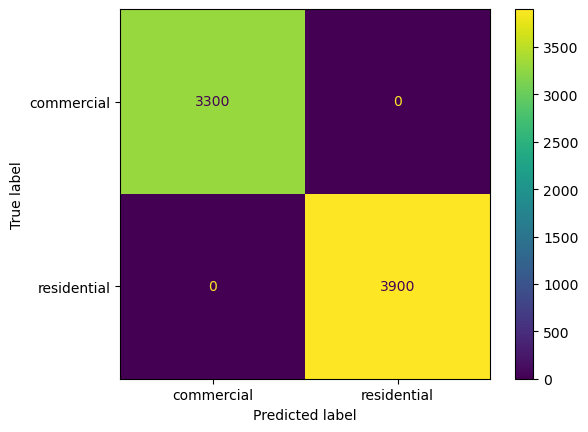

In [11]:
cm  = confusion_matrix(df["building_stock_type"], df["oof_building_stock_type"])
cmd = ConfusionMatrixDisplay(cm, display_labels=['commercial', 'residential'])
cmd.plot()

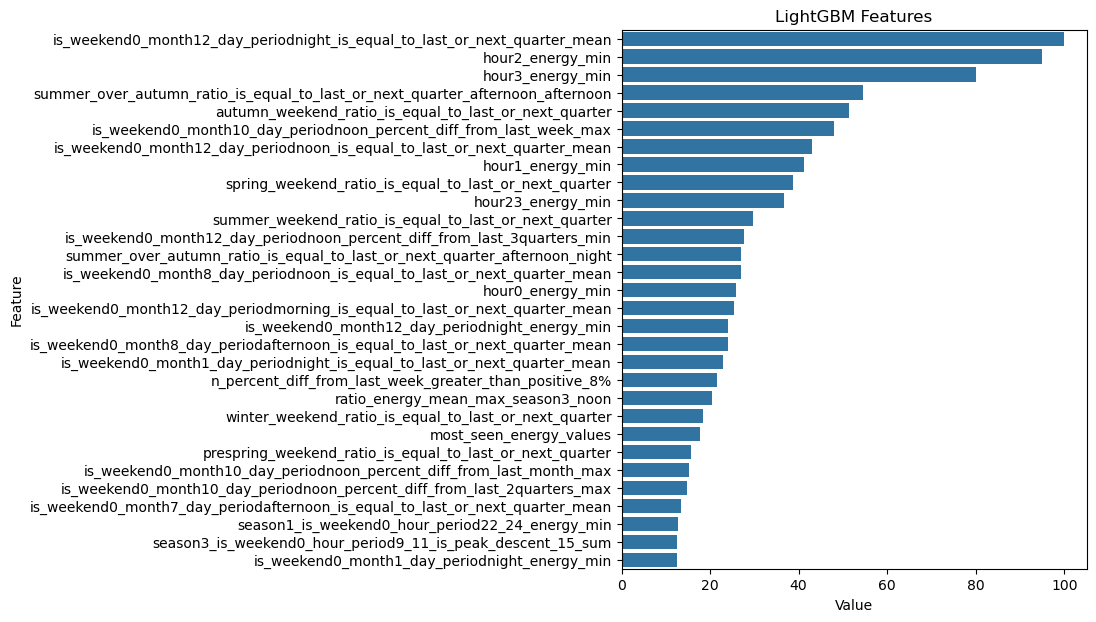

In [12]:
# Features Importance
plt.figure(figsize=(6, 7))
sns.barplot(x="Value", y="Feature", data=Feature_Imp.head(30))
plt.title('LightGBM Features')
plt.show()

___
___
# **Modelisation n°2 : residential and commercial columns**

In [13]:
# Clip to avoid very rare classes (this avoids problems in kfolk strategy and stabilize the predictions)
df['in.weekday_operating_hours..hr_com'] = df['in.weekday_operating_hours..hr_com'].astype(float).clip(None, 18.5).astype(str)

### **Model parameters**

In [14]:
DICT_OF_PARAMS = { 
                    'in.tenure_res' : {'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 2, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.041889527304908025, 'reg_alpha': 0.08053331703646527, 'reg_lambda': 3.580014368497408, 'max_depth': 7, 'colsample_bytree': 0.17093308529254253, 'subsample': 0.9088682557499383, 'min_child_samples': 132, 'num_leaves': 1938, 'class_weight': 'balanced', 'num_classes': 1},
                    'in.bedrooms_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.030121325902926387, 'reg_alpha': 1.1864029521652464, 'reg_lambda': 1.9260145819916845, 'max_depth': 6, 'colsample_bytree': 0.3539960855841303, 'subsample': 0.6052116066570076, 'min_child_samples': 244, 'num_leaves': 1656, 'class_weight': 'balanced', 'num_classes': 5},
                    'in.heating_fuel_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.11673388264309578, 'reg_alpha': 4.980764685872586, 'reg_lambda': 4.628074138912934, 'max_depth': 10, 'colsample_bytree': 0.2989211695687975, 'subsample': 0.21681397232298263, 'min_child_samples': 217, 'num_leaves': 784, 'class_weight': 'balanced', 'num_classes': 6},
                    'in.geometry_wall_type_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 2, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.08560247998860124, 'reg_alpha': 3.5073472209173784, 'reg_lambda': 4.409357478428665, 'max_depth': 11, 'colsample_bytree': 0.4854340322142013, 'subsample': 0.7738030207353128, 'min_child_samples': 118, 'num_leaves': 1708, 'class_weight': 'balanced', 'num_classes': 4},
                    'in.vacancy_status_res' : {'objective': 'binary', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.08107111537243183, 'reg_alpha': 0.7581367625568265, 'reg_lambda': 1.103675519421502, 'max_depth': 8, 'colsample_bytree': 0.05, 'subsample': 0.9351622168374029, 'min_child_samples': 63, 'num_leaves': 1544, 'class_weight': 'balanced', 'num_classes': 1},
                    'in.roof_material_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.1001499610087202, 'reg_alpha': 3.1437730102452783, 'reg_lambda': 4.909459426012415, 'max_depth': 15, 'colsample_bytree': 0.7753115922975213, 'subsample': 0.6601837117541987, 'min_child_samples': 259, 'num_leaves': 866, 'class_weight': 'balanced', 'num_classes': 7},
                    'in.income_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.0632204896884604, 'reg_alpha': 4.636674564074927, 'reg_lambda': 1.4669551918973003, 'max_depth': 11, 'colsample_bytree': 0.6188818629070363, 'subsample': 0.2489511873757623, 'min_child_samples': 151, 'num_leaves': 1958, 'class_weight': 'balanced', 'num_classes': 19},
                    'in.geometry_building_type_recs_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.033288228170179145, 'reg_alpha': 4.930848050287617, 'reg_lambda': 1.6047270128397768, 'max_depth': 9, 'colsample_bytree': 0.14337505834702274, 'subsample': 0.5721535190251661, 'min_child_samples': 143, 'num_leaves': 1321, 'class_weight': 'balanced', 'num_classes': 5},
                    'in.vintage_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.03370675455126148, 'reg_alpha': 4.098812829140237, 'reg_lambda': 0.05699152935959806, 'max_depth': 11, 'colsample_bytree': 0.10286684975128067, 'subsample': 0.3982006586761714, 'min_child_samples': 230, 'num_leaves': 427, 'class_weight': 'balanced', 'num_classes': 9},
                    'in.heating_setpoint_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.02918782660205753, 'reg_alpha': 4.713212364423259, 'reg_lambda': 1.1899485931930256, 'max_depth': 8, 'colsample_bytree': 0.21287215574626106, 'subsample': 0.49267727895829605, 'min_child_samples': 160, 'num_leaves': 1288, 'class_weight': 'balanced', 'num_classes': 12},
                    'in.cooling_setpoint_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.06577922341176737, 'reg_alpha': 4.211599380517061, 'reg_lambda': 1.6470954755071754, 'max_depth': 11, 'colsample_bytree': 0.22399833529368868, 'subsample': 0.47457938260233634, 'min_child_samples': 299, 'num_leaves': 1058, 'class_weight': 'balanced', 'num_classes': 11},
                    'in.geometry_floor_area_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.044385660179153276, 'reg_alpha': 4.18620547680628, 'reg_lambda': 5.244234938043471, 'max_depth': 10, 'colsample_bytree': 0.4001330629574603, 'subsample': 0.6536103591994937, 'min_child_samples': 241, 'num_leaves': 1522, 'class_weight': 'balanced', 'num_classes': 9},
                    'in.geometry_foundation_type_res' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.04644680615243484, 'reg_alpha': 2.357954171496769, 'reg_lambda': 3.557313563291898, 'max_depth': 12, 'colsample_bytree': 0.31602152860577626, 'subsample': 0.8700742290870591, 'min_child_samples': 138, 'num_leaves': 1841, 'class_weight': 'balanced', 'num_classes': 6},
                    'in.comstock_building_type_group_com' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.05324957401306494, 'reg_alpha': 0.008953454803743988, 'reg_lambda': 2.5562675293877026, 'max_depth': 8, 'colsample_bytree': 0.6688477153642391, 'subsample': 0.4183781828362673, 'min_child_samples': 169, 'num_leaves': 1432, 'class_weight': 'balanced', 'num_classes': 7},
                    'in.heating_fuel_com' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.03396665686866536, 'reg_alpha': 3.580477171565355, 'reg_lambda': 3.7408252500511825, 'max_depth': 10, 'colsample_bytree': 0.06416918901519675, 'subsample': 0.7222083742926959, 'min_child_samples': 212, 'num_leaves': 1935, 'class_weight': 'balanced', 'num_classes': 5},
                    'in.hvac_category_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.05325595635695457, 'reg_alpha': 1.0367477810375743, 'reg_lambda': 0.7354255883509447, 'max_depth': 13, 'colsample_bytree': 0.3167774646314515, 'subsample': 0.4890480253637717, 'min_child_samples': 105, 'num_leaves': 187, 'class_weight': 'balanced', 'num_classes': 5},
                    'in.number_of_stories_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.08137116405563954, 'reg_alpha': 3.6726179229991294, 'reg_lambda': 2.7662703749001576, 'max_depth': 10, 'colsample_bytree': 0.2982175970261986, 'subsample': 0.5611943520572902, 'min_child_samples': 135, 'num_leaves': 650, 'class_weight': 'balanced', 'num_classes': 15},
                    'in.ownership_type_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.07701927164769078, 'reg_alpha': 4.072084948139849, 'reg_lambda': 3.388122533800149, 'max_depth': 8, 'colsample_bytree': 0.07684883385411617, 'subsample': 0.3407440351113464, 'min_child_samples': 90, 'num_leaves': 1676, 'class_weight': 'balanced', 'num_classes': 5},
                    'in.vintage_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.05468943240556485, 'reg_alpha': 9.966277042997723, 'reg_lambda': 9.747977895985379, 'max_depth': 8, 'colsample_bytree': 0.3249498084884038, 'subsample': 0.406316968635829, 'min_child_samples': 192, 'num_leaves': 1307, 'class_weight': 'balanced', 'num_classes': 8},
                    'in.wall_construction_type_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.1666744083740118, 'reg_alpha': 9.28085003346311, 'reg_lambda': 0.010807244127688437, 'max_depth': 8, 'colsample_bytree': 0.546675852512235, 'subsample': 0.8381237522029539, 'min_child_samples': 232, 'num_leaves': 733, 'class_weight': 'balanced', 'num_classes': 4},
                    'in.tstat_clg_sp_f..f_com'  : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.13937122022079113, 'reg_alpha': 5.287216342981687, 'reg_lambda': 7.015578506098778, 'max_depth': 8, 'colsample_bytree': 0.12619503803656307, 'subsample': 0.303969841631694, 'min_child_samples': 114, 'num_leaves': 651, 'class_weight': 'balanced', 'num_classes': 12},
                    'in.tstat_htg_sp_f..f_com' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 50000, 'n_jobs': 8, 'learning_rate': 0.15576222938213818, 'reg_alpha': 3.2404357383573545, 'reg_lambda': 3.9849206889171187, 'max_depth': 10, 'colsample_bytree': 0.5347511814645929, 'subsample': 0.9064906785233057, 'min_child_samples': 88, 'num_leaves': 2015, 'class_weight': 'balanced', 'num_classes': 12}, 
                    'in.weekday_opening_time..hr_com' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 5000, 'n_jobs': 8, 'learning_rate': 0.05633349746386906, 'reg_alpha': 2.272989136075, 'reg_lambda': 7.850468561314934, 'max_depth': 5, 'colsample_bytree': 0.3696035596991193, 'subsample': 0.7780374474054992, 'min_child_samples': 212, 'num_leaves': 673, 'class_weight': 'balanced', 'num_classes': 36},
                    'in.weekday_operating_hours..hr_com' : {'objective': 'multiclass', 'verbosity': -1, 'boosting_type': 'gbdt', 'random_state': 12, 'n_estimators': 8000, 'n_jobs': 8, 'learning_rate': 0.01397214438051675, 'reg_alpha': 0.7659819439170086, 'reg_lambda': 5.261321935482891, 'max_depth': 4, 'colsample_bytree': 0.30499067446759454, 'subsample': 0.21154049714398365, 'min_child_samples': 50, 'num_leaves': 1672, 'class_weight': 'balanced'},
                 }


len(DICT_OF_PARAMS)

24

## **Train models**

In [15]:
def train_model(df, test, feats, var_to_predict, DICT_OF_PARAMS=DICT_OF_PARAMS):
    
    # Number of classes
    n_classes = df[var_to_predict].nunique()
    
    # Print info
    print('\n' + '='*60)
    print(f"{var_to_predict} : {n_classes} classes / {len(feats)} feats.\n")
    
    # Initialize
    df_preds   = np.zeros((len(df), n_classes))
    test_preds = np.zeros((len(test), n_classes))
    fit_params = {"eval_metric" : "logloss" if n_classes==2 else "multi_logloss",
                  "eval_names": ['train', 'valid']}
    
    # Model parameter
    param = DICT_OF_PARAMS[var_to_predict]

    # Create a column to store out-of-folds scores (oof)
    df[f"oof_{var_to_predict}"] = 0
    test[f"oof_{var_to_predict}"] = 0

    # KFOLD
    n_splits = get_n_splits(n_classes)
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=12)

    # ----------------------------------------------------------------------------------------
    # Model training (loop over all folds)
    for fold, (train_idx, test_idx) in enumerate(kfold.split(df[feats], df[var_to_predict])):

        # -------------------------------------------------------------------------------------------------------------------------------------------------
        # MODEL TRAINING

        # Create train & test
        xtr, ytr = df.loc[train_idx, feats], df.loc[train_idx, var_to_predict]
        xte, yte = df.loc[test_idx, feats], df.loc[test_idx, var_to_predict]

        # Create model
        model = lgb.LGBMClassifier(**param)

        # Fit params
        fit_params["eval_set"] = [(xtr, ytr), (xte, yte)]

        # Fit model
        model.fit(xtr, ytr,
                  **fit_params,
                  callbacks = [lgb.log_evaluation(0),
                               lgb.early_stopping(40, verbose=0),
                              ]
                 )
        
        # Save model
        joblib.dump(model, model_dir + f"{var_to_predict}_fold{fold}.joblib")

        # Get score of the fold (cross-validation)
        pred_probas = model.predict_proba(xte)
        preds = model.predict(xte)
        df_preds[test_idx] = pred_probas
        test_preds += model.predict_proba(test[feats]) / n_splits

        # Print CV-score
        acc = accuracy_score(yte, preds)
        f1  = f1_score(yte, preds, average='macro')
        print(f"Fold {str(fold).ljust(2)} : acc = {str(round(acc, 4)).ljust(6)} / f1 = {str(round(f1, 4)).ljust(6)}.")

    # ---------------------------------------------------------------------------------------------------
    # Final score
    df[f"oof_{var_to_predict}"] = model.classes_[df_preds.argmax(axis=1)]
    acc = accuracy_score(df[var_to_predict].astype(str), df[f"oof_{var_to_predict}"].astype(str))
    f1  = f1_score(df[var_to_predict].astype(str), df[f"oof_{var_to_predict}"].astype(str), average='macro')
    print(f"Final CV : Accuracy = {str(round(acc, 4)).ljust(6)} / f1 = {str(round(f1, 4)).ljust(6)}.\n")

    # ================================================================================================
    # Model ENSEMBLE
    df[f"oof_{var_to_predict}"] = model.classes_[df_preds.argmax(axis=1)]
    test[var_to_predict]        = model.classes_[test_preds.argmax(axis=1)]
        
    # ================================================================================================
    # Thresholds optimization to maximize f1-score (better than just taking argmax)
    objective = OptunaRounder(y_true = df[var_to_predict],
                              y_pred = df_preds,
                              class_names = model.classes_,
                             )
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
    n_trials = np.clip(100*n_classes, 300, 1500) # 100 trials per class, min 300 trials, max 1500 trials
    study.optimize(objective, n_trials=n_trials, n_jobs=1, timeout=600) # Iime limit : 10 minutes (600 secondes)
    best_thresholds = list(study.best_params.values())
    
    # Save thresholds
    joblib.dump(best_thresholds, thr_dir + f"thr_{var_to_predict}.joblib")
    
    df[f"oof_{var_to_predict}"] = get_preds_from_thresholds(y_pred = df_preds, labels=model.classes_, thresholds=best_thresholds)
    test[var_to_predict]        = get_preds_from_thresholds(y_pred = test_preds, labels=model.classes_, thresholds=best_thresholds)

    print("********* ENSEMBLE thresholds *********")
    for fold, (train_idx, test_idx) in enumerate(kfold.split(df[feats], df[var_to_predict])):
        yte   = df.loc[test_idx, var_to_predict]
        preds = df.loc[test_idx, f"oof_{var_to_predict}"]
        acc = accuracy_score(yte, preds)
        f1  = f1_score(yte, preds, average='macro')
        print(f"Fold {str(fold).ljust(2)} : acc = {str(round(acc, 4)).ljust(6)} / f1 = {str(round(f1, 4)).ljust(6)}.")
    acc = accuracy_score(df[var_to_predict].astype(str), df[f"oof_{var_to_predict}"].astype(str))
    f1  = f1_score(df[var_to_predict].astype(str), df[f"oof_{var_to_predict}"].astype(str), average='macro')
    print(f"ENSEMBLE thresholds: Accuracy = {str(round(acc, 4)).ljust(6)} / f1 = {str(round(f1, 4)).ljust(6)}.\n")
    
    return df[f"oof_{var_to_predict}"].values, test[var_to_predict].values

In [16]:
%%time

# PATHS to features
paths_to_feats = [x for x in os.listdir(feats_dir) if x.endswith('.joblib')]

# Train one model for each column to predict (loop)
for var_to_predict in list(DICT_OF_PARAMS.keys()) :
    
    # Features
    path_to_feats = sorted([x for x in paths_to_feats if x.startswith('feats_' + var_to_predict)])[0]
    feats = joblib.load(feats_dir+path_to_feats)
 
    # Get what type of building we are processing
    if var_to_predict.endswith('_res') :
        building_stock_type = 'residential'
    else :
        building_stock_type = 'commercial'

    # Train model and get oof
    mask_df, mask_test = (df["building_stock_type"] == building_stock_type), (test["building_stock_type"] == building_stock_type)
    oof, preds = train_model(df[mask_df].reset_index(drop=True),
                             test[mask_test].reset_index(drop=True),
                             feats,
                             var_to_predict,
                             )
        
    # Store oof and predictions
    df.loc[mask_df, f"oof_{var_to_predict}"] = oof
    test.loc[mask_test, var_to_predict] = preds
    
# Show
test[['bldg_id'] + cols_residential + cols_commercial].head()


in.tenure_res : 2 classes / 446 feats.

Fold 0  : acc = 0.7974 / f1 = 0.7816.
Fold 1  : acc = 0.8205 / f1 = 0.8024.
Fold 2  : acc = 0.7795 / f1 = 0.7626.
Fold 3  : acc = 0.8026 / f1 = 0.7852.
Fold 4  : acc = 0.8128 / f1 = 0.7982.
Fold 5  : acc = 0.7974 / f1 = 0.7789.
Fold 6  : acc = 0.8026 / f1 = 0.7884.
Fold 7  : acc = 0.7949 / f1 = 0.7771.
Fold 8  : acc = 0.7821 / f1 = 0.7689.
Fold 9  : acc = 0.7923 / f1 = 0.7767.
Final CV : Accuracy = 0.7982 / f1 = 0.782 .

********* ENSEMBLE thresholds *********
Fold 0  : acc = 0.8    / f1 = 0.784 .
Fold 1  : acc = 0.8231 / f1 = 0.8049.
Fold 2  : acc = 0.7795 / f1 = 0.7626.
Fold 3  : acc = 0.8051 / f1 = 0.7876.
Fold 4  : acc = 0.8154 / f1 = 0.8007.
Fold 5  : acc = 0.8    / f1 = 0.7813.
Fold 6  : acc = 0.8077 / f1 = 0.7933.
Fold 7  : acc = 0.7974 / f1 = 0.7796.
Fold 8  : acc = 0.7846 / f1 = 0.7713.
Fold 9  : acc = 0.7923 / f1 = 0.7761.
ENSEMBLE thresholds: Accuracy = 0.8005 / f1 = 0.7841.


in.bedrooms_res : 5 classes / 2600 feats.

Fold 0  : acc =

,bldg_id,in.bedrooms_res,in.cooling_setpoint_res,in.heating_setpoint_res,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,in.weekday_opening_time..hr_com,in.weekday_operating_hours..hr_com
0,1,1,75F,65F,Multi-Family with 5+ Units,500-749,Slab,Brick,Electricity,15000-19999,Composition Shingles,Renter,Occupied,2000s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,5,80F,65F,Single-Family Detached,2000-2499,Slab,Wood Frame,Natural Gas,200000+,"Tile, Clay or Ceramic",Owner,Occupied,2010s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Office,Electricity,Small Packaged Unit,2,owner_occupied,1980 to 1989,SteelFramed,74,69,8,8.75
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mercantile,NaturalGas,Small Packaged Unit,2,leased,Before 1946,SteelFramed,73,68,11,11.0
4,5,3,70F,68F,Single-Family Attached,1500-1999,Unheated Basement,Wood Frame,Natural Gas,15000-19999,Composition Shingles,Owner,Occupied,<1940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Create dataframes
df_res  = df[df["building_stock_type"] != 'commercial'].reset_index(drop=True)
test_res = test[test["building_stock_type"] != 'commercial'].reset_index(drop=True)


___
___
# **Cross-validation score**

In [18]:
# Create y_test and y_pred
cols = ['building_stock_type'] + cols_residential + cols_commercial
cols_oof = [f"oof_{x}" for x in cols]

# Delete '.0' suffix in str predictions ('10.0' -> '10'). This values appear due to float -> str conversion by pandas
for k in cols_residential + cols_commercial + cols_oof :
    df[k] = df[k].astype(str).apply(lambda x : x[:-2] if x.endswith('.0') else x)

# Set index for CV computation
y_test = df[['bldg_id'] + cols]
y_pred = df[['bldg_id'] + cols_oof].rename(columns = {k : k[4:] if k.startswith('oof_') else k for k in cols_oof})
y_test.index = y_test['bldg_id']
y_pred.index = y_pred['bldg_id']

In [19]:
# Compute F1 score
F1, F1_dict = calculate_hierarchical_f1_score(y_test,
                                              y_pred,
                                              alpha=0.4,
                                              average = 'macro',
                                              F1_list = True)
df_f1_scores = pd.DataFrame(list(F1_dict.items()), columns=['column name', 'Macro F1-score'])
df_f1_scores.set_index('column name', inplace=True)

# Print result
print(f'Hierarchical F1-score: {round(F1, 5)} \n')
df_f1_scores

F1 level 1     : 1.0
F1 commercial  : 0.4101
F1 residential : 0.4285
Hierarchical F1-score: 0.65158 



,Macro F1-score
column name,
building_stock_type,1.000000
in.vacancy_status_res,0.998232
in.comstock_building_type_group_com,0.978756
in.hvac_category_com,0.886120
in.tenure_res,0.784143
in.heating_fuel_com,0.579997
in.geometry_building_type_recs_res,0.562966
in.geometry_wall_type_res,0.548385
in.geometry_foundation_type_res,0.491380


___
___
# **Submission**

In [20]:
# Create submission
sub = test[['bldg_id'] + ['building_stock_type'] + cols_residential + cols_commercial]
sub.index = sub['bldg_id']
sub = sub[df_targets.columns]
sub = sub.drop(columns = ['bldg_id'])

# Delete '.0' suffix in str predictions ('10.0' -> '10'). This values appear due to float -> str conversion by pandas
for k in cols_residential + cols_commercial :
    sub[k] = sub[k].astype(str).apply(lambda x : x[:-2] if x.endswith('.0') else x)

# Export CSV
sub.to_parquet('submission.parquet')

# Show
print(sub.shape)
sub

(1440, 25)


,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,in.weekday_opening_time..hr_com,in.weekday_operating_hours..hr_com,in.bedrooms_res,in.cooling_setpoint_res,in.heating_setpoint_res,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res
bldg_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,75F,65F,Multi-Family with 5+ Units,500-749,Slab,Brick,Electricity,15000-19999,Composition Shingles,Renter,Occupied,2000s
2,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5,80F,65F,Single-Family Detached,2000-2499,Slab,Wood Frame,Natural Gas,200000+,"Tile, Clay or Ceramic",Owner,Occupied,2010s
3,commercial,Office,Electricity,Small Packaged Unit,2,owner_occupied,1980 to 1989,SteelFramed,74,69,8,8.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,commercial,Mercantile,NaturalGas,Small Packaged Unit,2,leased,Before 1946,SteelFramed,73,68,11,11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3,70F,68F,Single-Family Attached,1500-1999,Unheated Basement,Wood Frame,Natural Gas,15000-19999,Composition Shingles,Owner,Occupied,<1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,commercial,Warehouse and Storage,NaturalGas,Small Packaged Unit,1,leased,1946 to 1959,Mass,999,999,9,7.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1437,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,70F,55F,Single-Family Detached,3000-3999,Unheated Basement,Wood Frame,Electricity,25000-29999,Composition Shingles,Owner,Vacant,1980s
1438,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2,72F,68F,Multi-Family with 2 - 4 Units,750-999,Unheated Basement,Wood Frame,Natural Gas,25000-29999,Composition Shingles,Owner,Occupied,<1940


___
___
# **Post-processing**

In [21]:
# Copy
original_sub = sub.copy()

# Accuracy on comstock_building_type_group_com is very high, so the predictions are most likely exact.
# -> In training data, buildings ('Healthcare', 'Warehouse and Storage', 'Lodging') have only one value for tstat_htg and tstat_clg : 999.
mask = (sub['in.comstock_building_type_group_com'].isin(['Healthcare', 'Warehouse and Storage', 'Lodging']))
sub.loc[mask, 'in.tstat_htg_sp_f..f_com'] = '999'
sub.loc[mask, 'in.tstat_clg_sp_f..f_com'] = '999'

# Accuracy on comstock_building_type_group_com is very high, so the predictions are most likely exact.
# -> In training data, buildings 'Education' have only one value for number_of_stories : 1.
mask = (sub['in.comstock_building_type_group_com'] == 'Education')
sub.loc[mask, 'in.number_of_stories_com'] = '1'

# Accuracy on comstock_building_type_group_com is very high, so the predictions are most likely exact.
# -> In training data, buildings ('Education', 'Food Service', 'Mercantile') have never the value 999 for tstat_htg and tstat_clg.
# So we replace 999 with most common value, and we clip values to avoid predicting never-seen or very-rare values.
mask = (sub['in.comstock_building_type_group_com'].isin(['Education', 'Food Service', 'Mercantile']))
sub.loc[mask, 'in.tstat_htg_sp_f..f_com'] = sub.loc[mask, 'in.tstat_htg_sp_f..f_com'].apply(lambda x : x if x!='999' else '68').clip('65', None)
sub.loc[mask, 'in.tstat_clg_sp_f..f_com'] = sub.loc[mask, 'in.tstat_clg_sp_f..f_com'].apply(lambda x : x if x!='999' else '72').clip('70', '75')

# Accuracy on in.vacancy_status_res is very high, so the predictions are most likely exact.
# -> In training data, vacancy_status_res = 'Vacant' implies heating_setpoint = '55F'.
mask = (sub['in.vacancy_status_res'] == 'Vacant')
sub.loc[mask, 'in.heating_setpoint_res'] = '55F'

# =====================================================================
# Print how many rows were post-processed
n = len(original_sub.compare(sub))
print(f"Rows changed : {n}/{len(sub)}.")

# =====================================================================
# Export CSV
sub.to_parquet('submission.parquet')
sub.head()

Rows changed : 12/1440.


,building_stock_type,in.comstock_building_type_group_com,in.heating_fuel_com,in.hvac_category_com,in.number_of_stories_com,in.ownership_type_com,in.vintage_com,in.wall_construction_type_com,in.tstat_clg_sp_f..f_com,in.tstat_htg_sp_f..f_com,in.weekday_opening_time..hr_com,in.weekday_operating_hours..hr_com,in.bedrooms_res,in.cooling_setpoint_res,in.heating_setpoint_res,in.geometry_building_type_recs_res,in.geometry_floor_area_res,in.geometry_foundation_type_res,in.geometry_wall_type_res,in.heating_fuel_res,in.income_res,in.roof_material_res,in.tenure_res,in.vacancy_status_res,in.vintage_res
bldg_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,75F,65F,Multi-Family with 5+ Units,500-749,Slab,Brick,Electricity,15000-19999,Composition Shingles,Renter,Occupied,2000s
2,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5,80F,65F,Single-Family Detached,2000-2499,Slab,Wood Frame,Natural Gas,200000+,"Tile, Clay or Ceramic",Owner,Occupied,2010s
3,commercial,Office,Electricity,Small Packaged Unit,2,owner_occupied,1980 to 1989,SteelFramed,74,69,8,8.75,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,commercial,Mercantile,NaturalGas,Small Packaged Unit,2,leased,Before 1946,SteelFramed,73,68,11,11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,residential,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3,70F,68F,Single-Family Attached,1500-1999,Unheated Basement,Wood Frame,Natural Gas,15000-19999,Composition Shingles,Owner,Occupied,<1940
